In [3]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

import cProfile
from time import time

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_smooth = lambda N: plt.cm.viridis(np.linspace(0,1,N))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


Error:  name 'average_atom_geometric' is not defined


In [15]:
%%time

# Aluminum
name='Al'
Z, A = 13, 27 

Ti_eV = 1 
# Te_eV = 10

# Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

rs = 2.985767276908717

####
R = 10*rs

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':2e-2 ,'Npoints':300,
             'name':name, 'ignore_vxc':False, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False}
npa_kwargs = {'initialize':True, 'gradient_correction':None,'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':1e-2 ,'Npoints':1000, 
              'name':name,'ignore_vxc':False, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs*3, 'use_full_ne_for_nf':False}

Te_eV_array = Ti_eV*np.geomspace(0.5,2000, num=20)
aa_list = []; npa_list = []
for i, Te_eV in enumerate(Te_eV_array):
    print("______________________")
    print("______________________")
    print(f"Iteration {i}/{len(Te_eV_array)}, Te = {Te_eV:0.2f} [eV]")
    # Te_AU = Te_eV*eV_to_AU
    # t0 = time()
    # aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
    # aa.solve_TF(verbose=False,  picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-2,  nmax = 1e3)
    # aa.set_uii_eff()
    # aa_list.append(aa);
    # print(f"AA time = {time()-t0:0.2e}")
    
    
    t0 = time()
    npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)
    npa.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-6, nmax = 1e3)
    npa.set_uii_eff()
    npa_list.append(npa)
    print(f"NPA time = {time()-t0:0.2e}")

______________________
______________________
Iteration 0/20, Te = 0.50 [eV]
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.490
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 7.764e+01
Exiting status 0, reverting to best index so far: 1221
Final iter:1222, Total Error: 9.826e-13
Intialized Potentials and Densities
Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     0.3772, change: 3.8735e-03 (converged=True)
	φe Err =  3.868e-11, φe change =  7.399e-01
	ne Err =  2.882e-01, ne change =  1.401e-02
	Q =  0.000e+00 -> -4.547e-13, 
	Zstar guess =  0.000e+00. Current Zstar:  2.485e+00 (converged=False)
	Change =  7.118e-01
__________________________________________
TF Iteration 1
	mu =     0.3767, change: 1.3472e-03 (converged=True)
	φe Err = -3.310e-12, φe change =  1.004e-01
	ne Err =  2.391


KeyboardInterrupt



##### Effective Ion-Ion Pair Potential $u_{ii}(r)$

AttributeError: 'NeutralPseudoAtom' object has no attribute 'T'

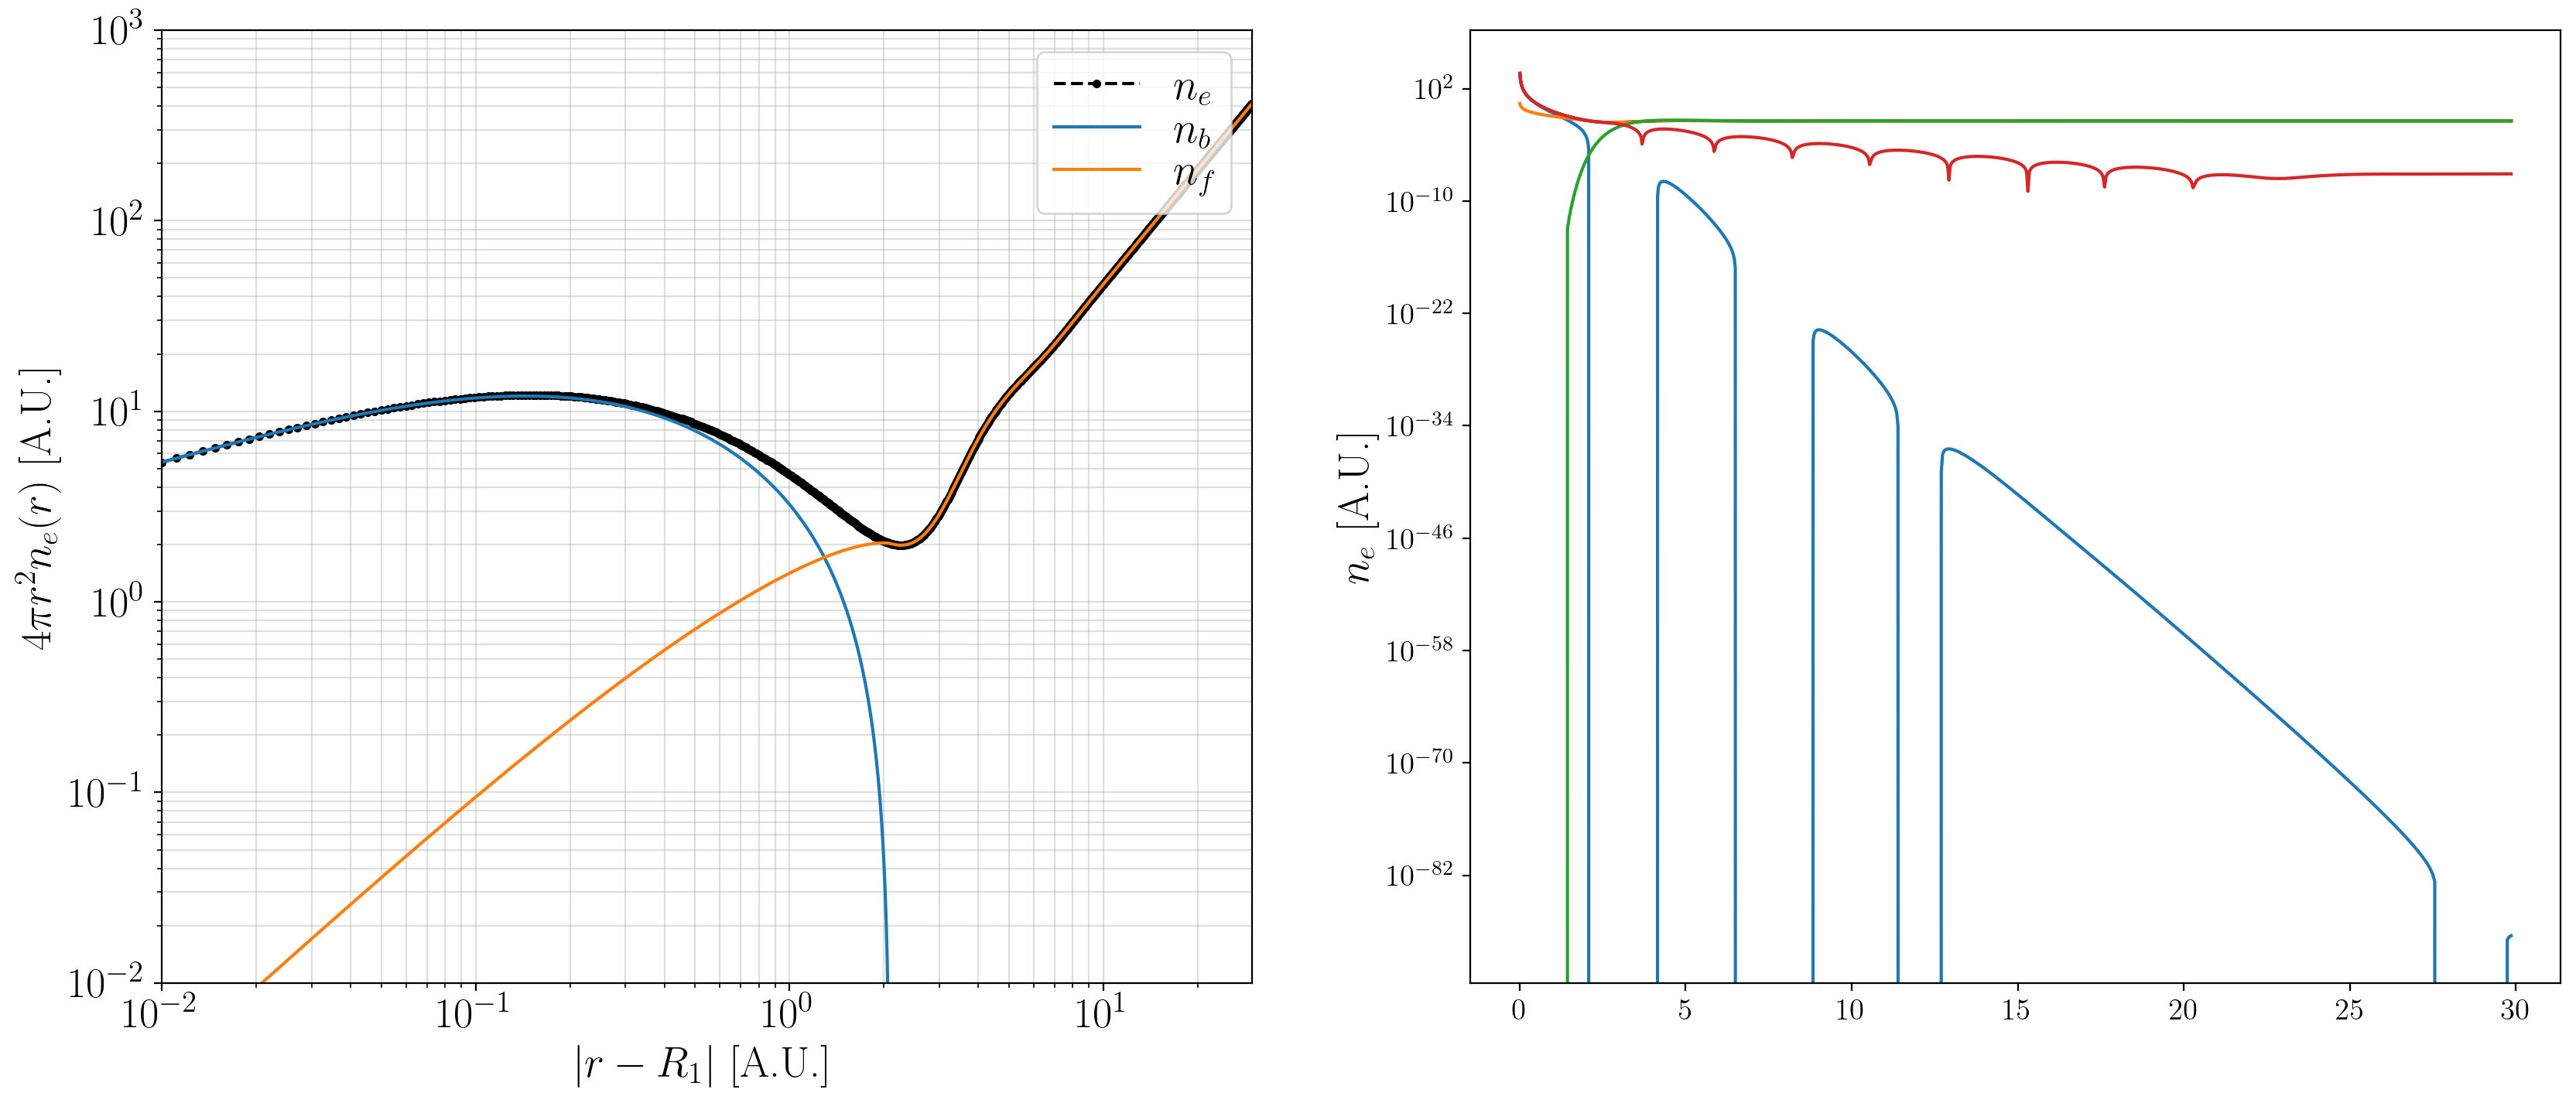

In [16]:
npa_list[0].make_plot_bound_free()

In [21]:
npa_list[0].uii_r_eff_iet

array([ 3.94858022e+02,  2.04391475e+02,  1.39781598e+02, ...,
       -1.85682263e-07, -1.04206858e-07, -1.88055134e-07])

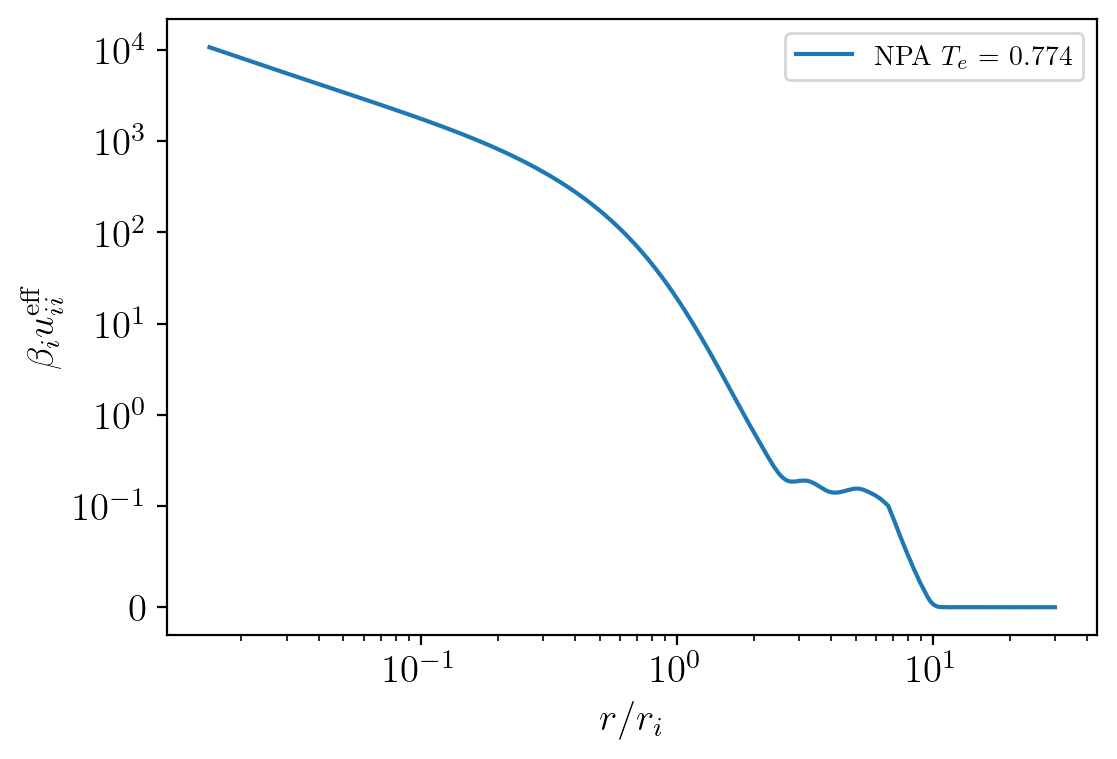

In [26]:
fig, ax = plt.subplots()


# for i, (aa, npa) in enumerate(zip(aa_list[:], npa_list[:])):
for i, npa in enumerate(npa_list[:17]):
    if i==0 or i==19:
        label=r"AA $T_e$ = {0:0.3f}".format(aa.Te*AU_to_eV)
    else:
        label=''
    # ax.plot(aa.iet.r_array, 1/aa.Ti * aa.uii_r_eff_iet,'-', color=color_smooth(20)[i], label=label )
    ax.plot(npa.iet.r_array, 1/aa.Ti * npa.uii_r_eff_iet,'-', color=color_cycle[i], label=r"NPA $T_e$ = {0:0.3f}".format(npa.Te*AU_to_eV) )
    
ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel(r"$\beta_i u^{\rm eff}_{ii}$")

ax.set_yscale('symlog', linthresh=1e-1)
ax.set_xscale('log')
# ax.set_xlim(2,5)

ax.legend(fontsize=10, loc='upper right')

##### Radial Distribution Function $g_{ii}(r)$

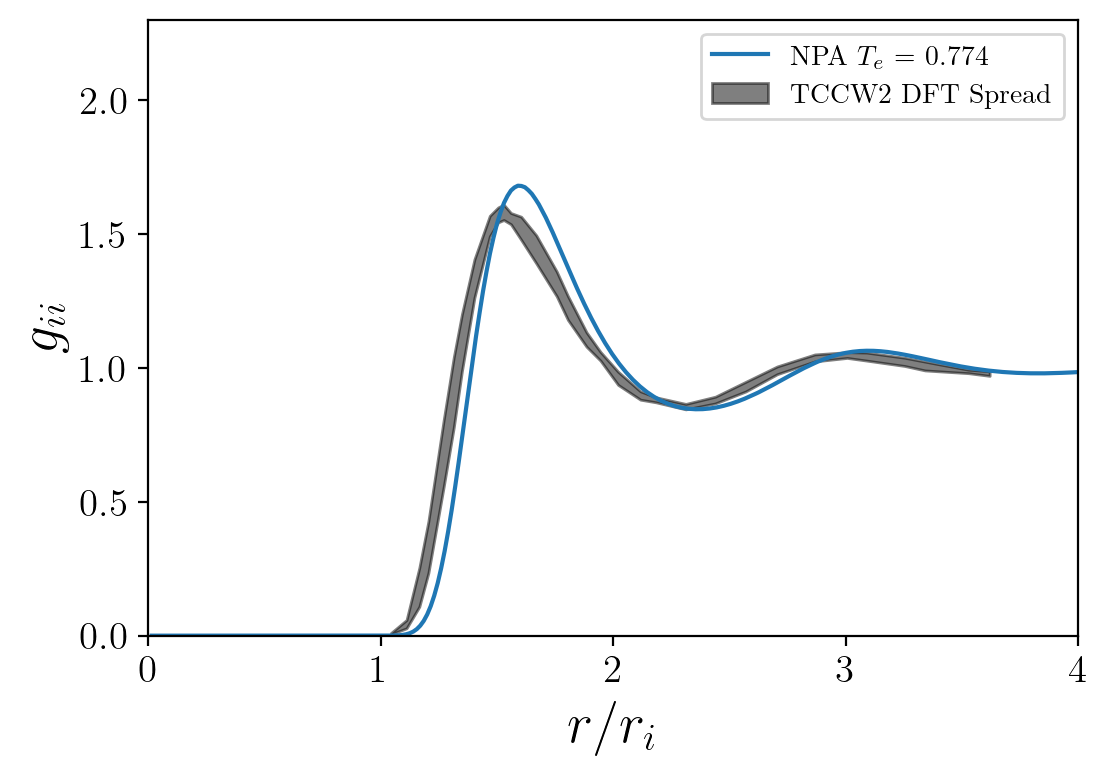

In [29]:
from pandas import read_csv
from scipy.interpolate import PchipInterpolator

fig, ax = plt.subplots()

# for i, (aa, npa) in enumerate(zip(aa_list[:], npa_list[:])):
for i, npa in enumerate(npa_list[:17]):
    if i==0 or i==16:
        label=r"AA $T_e$ = {0:0.3f}".format(aa.Te*AU_to_eV)
    else:
        label=''
    # ax.plot(aa.iet.r_array, aa.iet.h_r_matrix[0,0]+1,'--', color=color_smooth(20)[i], label=label )
    ax.plot(npa.iet.r_array, npa.iet.h_r_matrix[0,0]+1,'-', color=color_cycle[i], label=r"NPA $T_e$ = {0:0.3f}".format(npa.Te*AU_to_eV) )

# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='TCCW2 DFT Spread')


# make textbox
# text = ("{0}\n".format(aa.name)+ 
#     r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
#     r"$R_{NPA}$ = " + "{0} rs \n".format(npa.R/npa.rs)  +
#         r"$T_i$ = " + "{0:0.2f} eV\n".format(aa.Ti*AU_to_eV) + r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

# props = dict(boxstyle='round', facecolor='w')
# ax.text(0.05,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', bbox=props)

        
ax.set_xlim(0,4)
ax.set_ylim(0,2.3)

ax.set_xlabel(r"$r/r_i$", fontsize=20)
ax.set_ylabel(r"$g_{ii}$", fontsize=20)
ax.legend(fontsize=10, loc='upper right')

##### Static Structure factor $S_{}(k,0)$

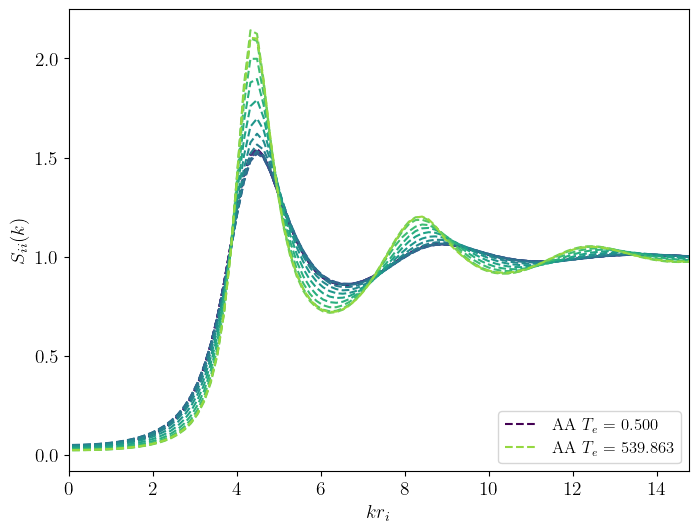

In [42]:
fig, ax = plt.subplots()

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# for i, (aa, npa) in enumerate(zip(aa_list[:], npa_list[:])):
for i, aa in enumerate(aa_list[:17]):
    if i==0 or i==16:
        label=r"AA $T_e$ = {0:0.3f}".format(aa.Te*AU_to_eV)
    else:
        label=''
    ax.plot(aa.iet.k_array, aa.iet.S_k_matrix[0,0],'--', color=color_smooth(20)[i], label=label)
    # ax.plot(npa.iet.k_array, npa.iet.S_k_matrix[0,0],'-', color=color_cycle[i], label=r"NPA $T_e$ = {0:0.3f}".format(npa.Te*AU_to_eV) )

# # make textbox
# text = ("{0}\n".format(aa.name)+ 
#     r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
#     r"$R_{NPA}$ = " + "{0} rs \n".format(npa.R/npa.rs)  +
#         r"$T_i$ = " + "{0:0.2f} eV\n".format(aa.Ti*AU_to_eV) + r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

# props = dict(boxstyle='round', facecolor='w')
# ax.text(0.05,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', bbox=props)

ax.set_xlim(0,10*aa.kF)

ax.set_xlabel(r"$k r_i$")
ax.set_ylabel(r"$S_{ii}(k)$")
ax.legend(fontsize=12, loc='lower right')

### Zstar

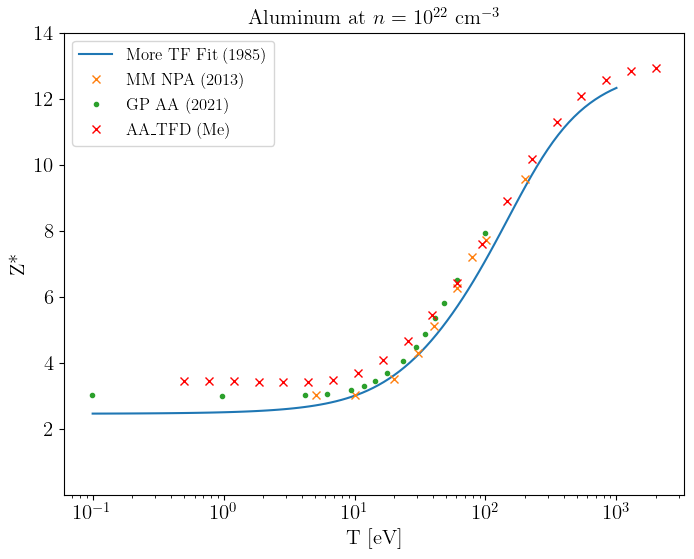

In [46]:
MM_NPA_Ts, MM_NPA_Zstars = np.array([[5.11450504972058,   3.0163934426229506],
[10.104496381022852,  3.027322404371585],
[20.067028615617833, 3.5081967213114753],
[30.256078694746794,   4.28415300546448],
[40.26856374600249,  5.103825136612022],
[60.08707154412468, 6.251366120218579],
[79.5567807021131, 7.191256830601093],
[101.04496381022851, 7.726775956284153],
[199.62996638292896, 9.562841530054644]] ).T

GP_AA_Ts, GP_AA_Zstars = np.array([[0.0992662705695525,  3.014888337468983],
[0.980553321974707,   3.002481389578164],
[4.214377896234591,  3.0272952853598016],
[6.180801214239726,  3.0521091811414394],
[9.335750868773577,   3.176178660049628],
[14.205352845215044,  3.449131513647643],
[11.729955789899613, 3.3002481389578167],
[17.848394113818813, 3.6848635235732012],
[23.26685803023974,  4.0446650124069485],
[29.66753407786115,   4.491315136476427],
[34.62945279460377,   4.863523573200993],
[41.02101447998807,   5.359801488833747],
[48.23573160038079,   5.806451612903226],
[60.606051630880664,  6.501240694789082],
[100., 7.928039702233251]]).T

dense_T_eV = np.geomspace(0.1, 1000,num=100)
More_Ts, More_Zstars = dense_T_eV, More_TF_Zbar(Z, aa.ni_bar, dense_T_eV*eV_to_AU) 

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(More_Ts, More_Zstars, '-',label='More TF Fit (1985)')
ax.plot(MM_NPA_Ts, MM_NPA_Zstars, 'x',label='MM NPA (2013)')
ax.plot(GP_AA_Ts, GP_AA_Zstars, '.',label='GP AA (2021)')

# ax.plot(amdis_Ts, amdis_Zstars,'-', label= 'AMDIS data')
# ax.plot(Te_eV_array, [npa.Zstar for npa in npa_list],'xk', label='{} (Me)'.format(npa.aa_type))
ax.plot(Te_eV_array, [aa.Zstar for aa in aa_list],'xr', label='{} (Me)'.format(aa.aa_type))

ax.set_ylim(1e-2,14)

# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(r'Aluminum at $n=10^{22}$ cm$^{-3}$',fontsize=15)
ax.set_ylabel('Z*',fontsize=15)
ax.set_xlabel("T [eV]",fontsize=15)
ax.tick_params(labelsize=15)
ax.legend(fontsize=12)